In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

df_origin = pd.read_csv('../../../datasets/house_prices_kaggle/train.csv')
df = df_origin.copy()
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
print(df.shape)
print(df.dtypes.value_counts())
isnull_series = df.isnull().sum()
print(isnull_series[isnull_series > 0].sort_values(ascending=False))

(1460, 81)
object     43
int64      35
float64     3
dtype: int64
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

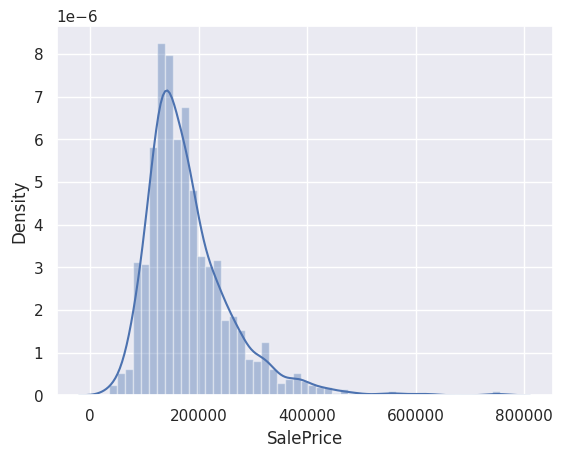

In [3]:
sns.distplot(df['SalePrice'])

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

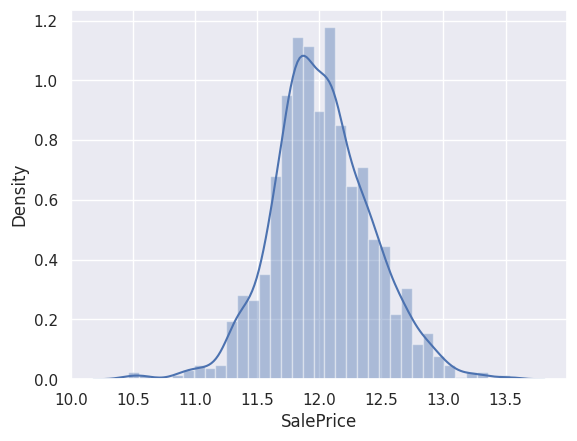

In [4]:
log_SalePrice = np.log1p(df['SalePrice'])
sns.distplot(log_SalePrice)

In [5]:
origin_SalePrice = df['SalePrice']
df['SalePrice'] = np.log1p(df['SalePrice'])

df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)
df.fillna(df.mean(), inplace=True)

null_column_count = df.isnull().sum()[df.isnull().sum() > 0]
print(df.dtypes[null_column_count.index])

MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [6]:
def get_value_counts(df, columns):
    for col in columns:
        print(col + ' counted values :', len(df[col].value_counts()))

get_value_counts(df, null_column_count.index.values)

MasVnrType counted values : 4
BsmtQual counted values : 4
BsmtCond counted values : 4
BsmtExposure counted values : 4
BsmtFinType1 counted values : 6
BsmtFinType2 counted values : 6
Electrical counted values : 5
GarageType counted values : 6
GarageFinish counted values : 3
GarageQual counted values : 5
GarageCond counted values : 5


In [7]:
print(df.shape)
df_ohe = pd.get_dummies(df)
print(df_ohe.shape)

null_column_count = df_ohe.isnull().sum()[df_ohe.isnull().sum() > 0]
print(df_ohe.dtypes[null_column_count.index])

(1460, 75)
(1460, 271)
Series([], dtype: object)


In [16]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, 'RMSE:', np.round(rmse, 3))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [17]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = df_ohe['SalePrice']
X_features = df_ohe.drop('SalePrice', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression RMSE: 307.221
Ridge RMSE: 0.203
Lasso RMSE: 0.265


[307.2214487316674, 0.2026474477925072, 0.265439139790745]

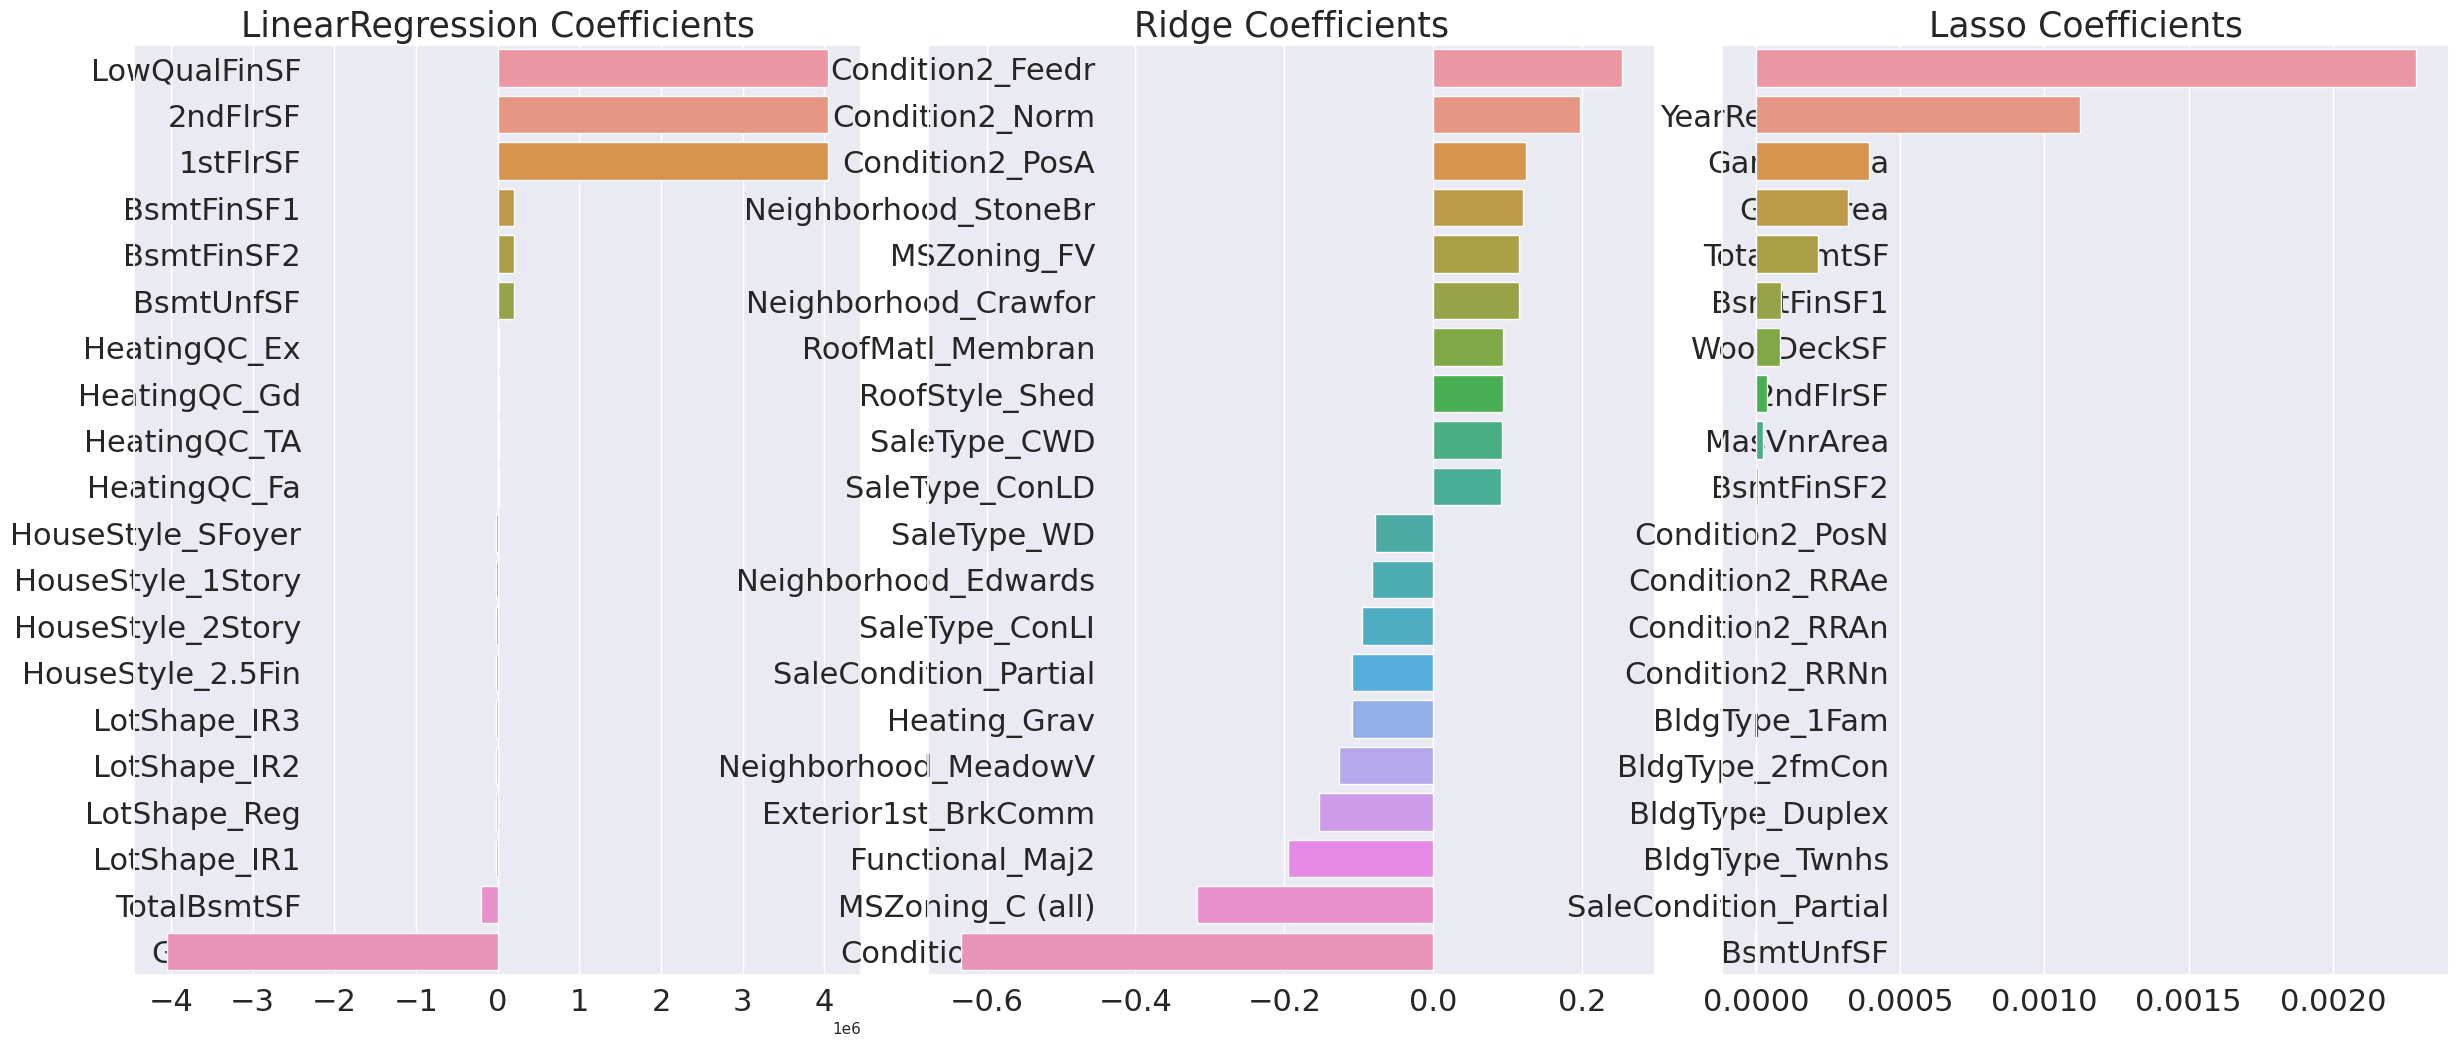

In [18]:
def get_top_bottom_coef(model, n=10):
    coef = pd.Series(model.coef_, index=X_features.columns)

    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

def visualize_coefficient(models):
    fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=len(models))
    fig.tight_layout()

    for i_num, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        axs[i_num].set_title(model.__class__.__name__ + ' Coefficients', size=25)
        axs[i_num].tick_params(axis='y', direction='in', pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

visualize_coefficient(models)

In [19]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):

    for model in models:
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring='neg_mean_squared_error', cv=5))
        rmse_avg = np.mean(rmse_list)
        print('{0} CV RMSE 값 리스트 : {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값 : {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))

get_avg_rmse_cv(models)

LinearRegression CV RMSE 값 리스트 : [1.350000e-01 2.467683e+03 1.680000e-01 1.110000e-01 1.980000e-01]
LinearRegression CV 평균 RMSE 값 : 493.659
Ridge CV RMSE 값 리스트 : [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값 : 0.144
Lasso CV RMSE 값 리스트 : [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값 : 0.198


In [20]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE : {1}, 최적 alpha : {2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))

ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE : 0.1418, 최적 alpha : {'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE : 0.142, 최적 alpha : {'alpha': 0.001}


LinearRegression RMSE: 307.221
Ridge RMSE: 0.19
Lasso RMSE: 0.201


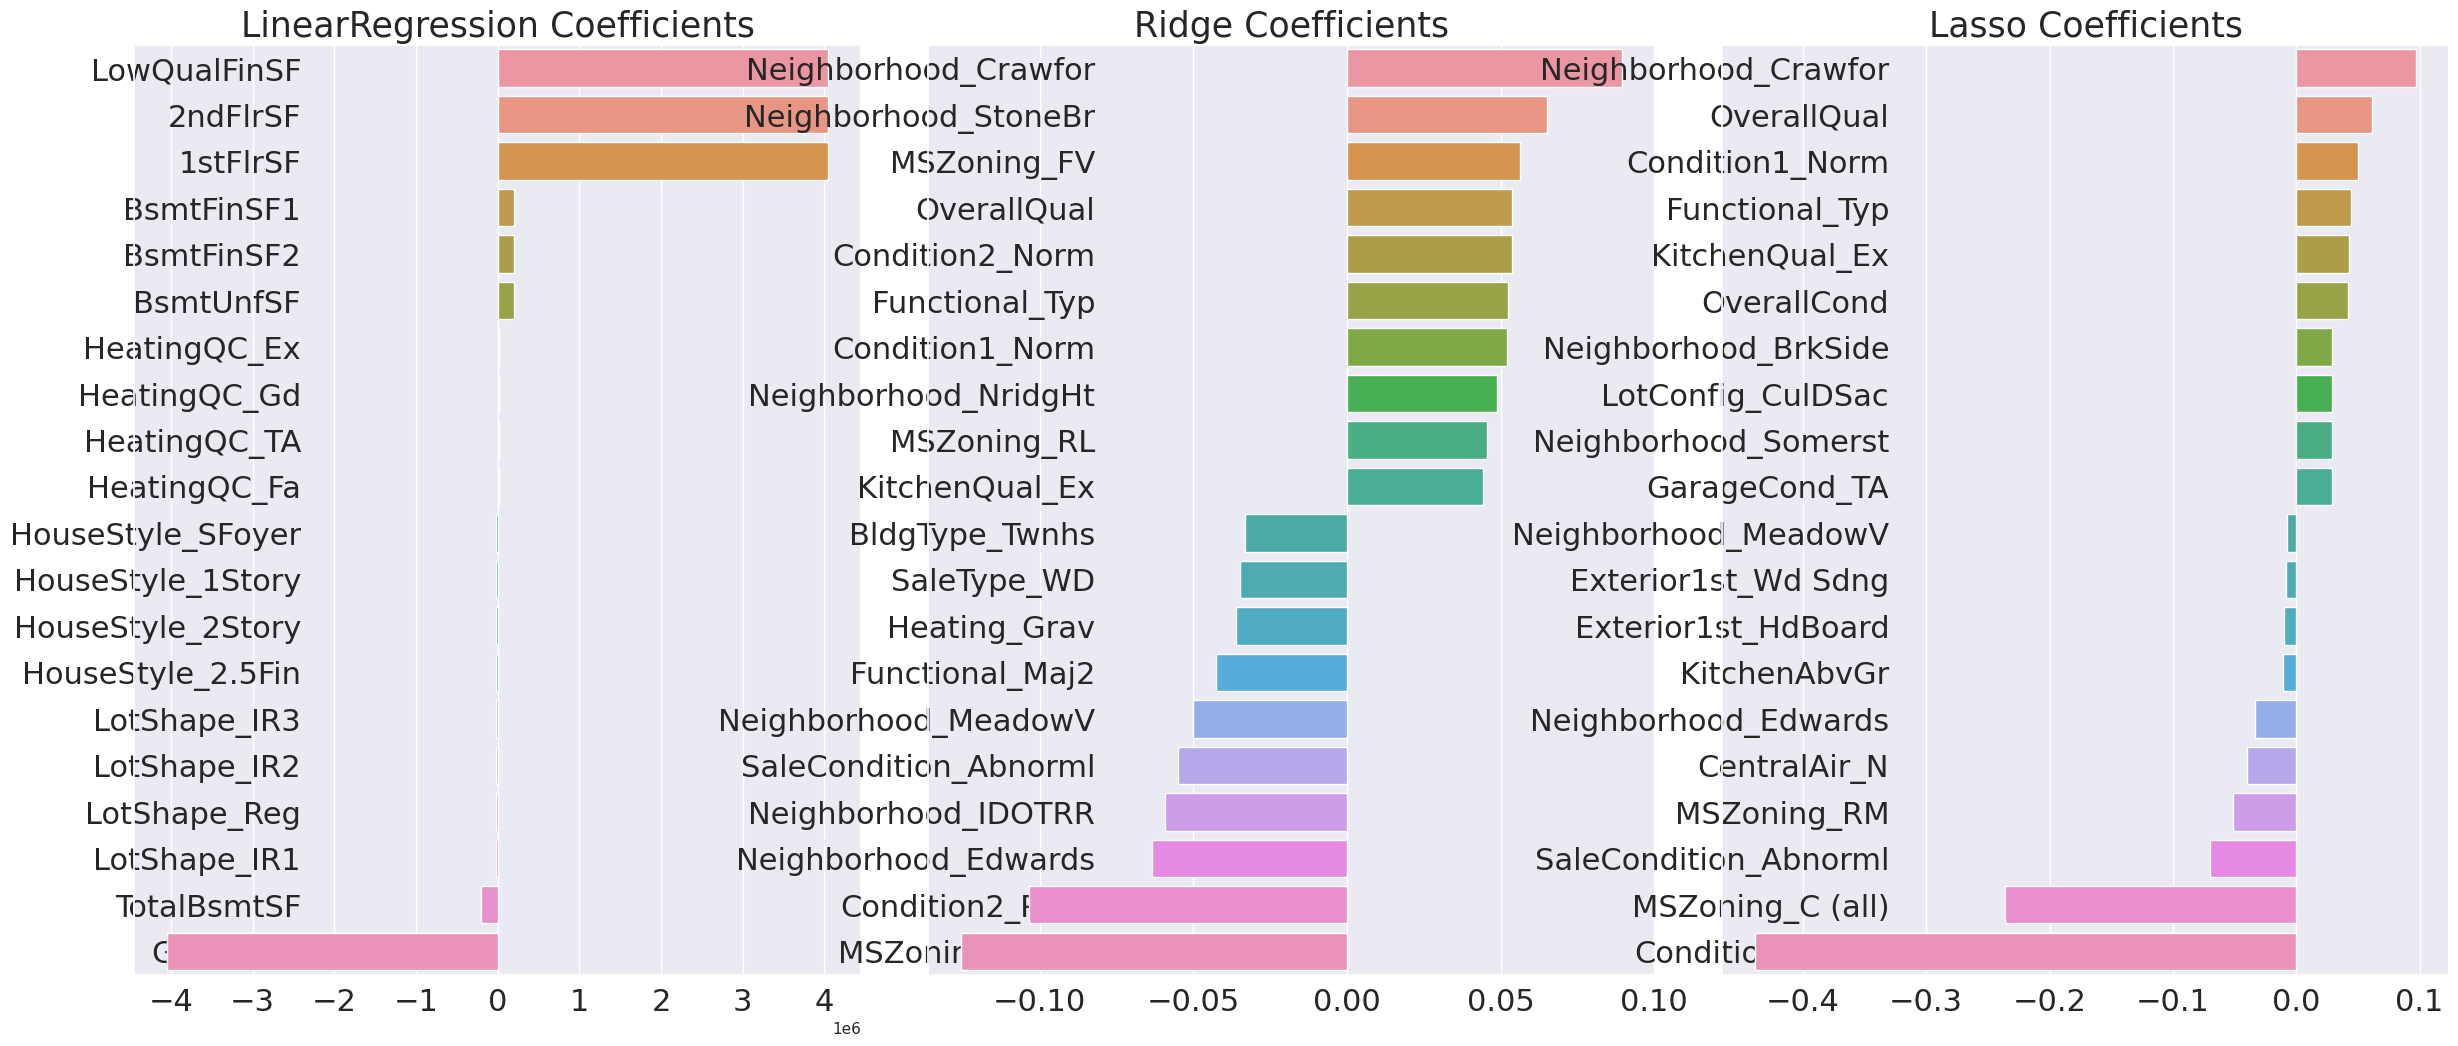

In [21]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
lasso_reg = lasso(alpha=12)
lasso_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, lasso_reg, lasso_reg]
get_rmses(models)
visualize_coefficient(models)

In [22]:
from scipy.stats import skew

features_index = df.dtypes[df.dtypes != 'object'].index
skew_features = df[features_index].apply(lambda x : skew(x))

skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [23]:
df[skew_features_top.index] = np.log1p(df[skew_features_top.index])

In [38]:
df_ohe = pd.get_dummies(df)
y_target = df_ohe['SalePrice']
X_features = df_ohe.drop('SalePrice', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE : 0.1275, 최적 alpha : {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE : 0.1252, 최적 alpha : {'alpha': 0.001}


LinearRegression RMSE: 0.128
Ridge RMSE: 0.122
Lasso RMSE: 0.119


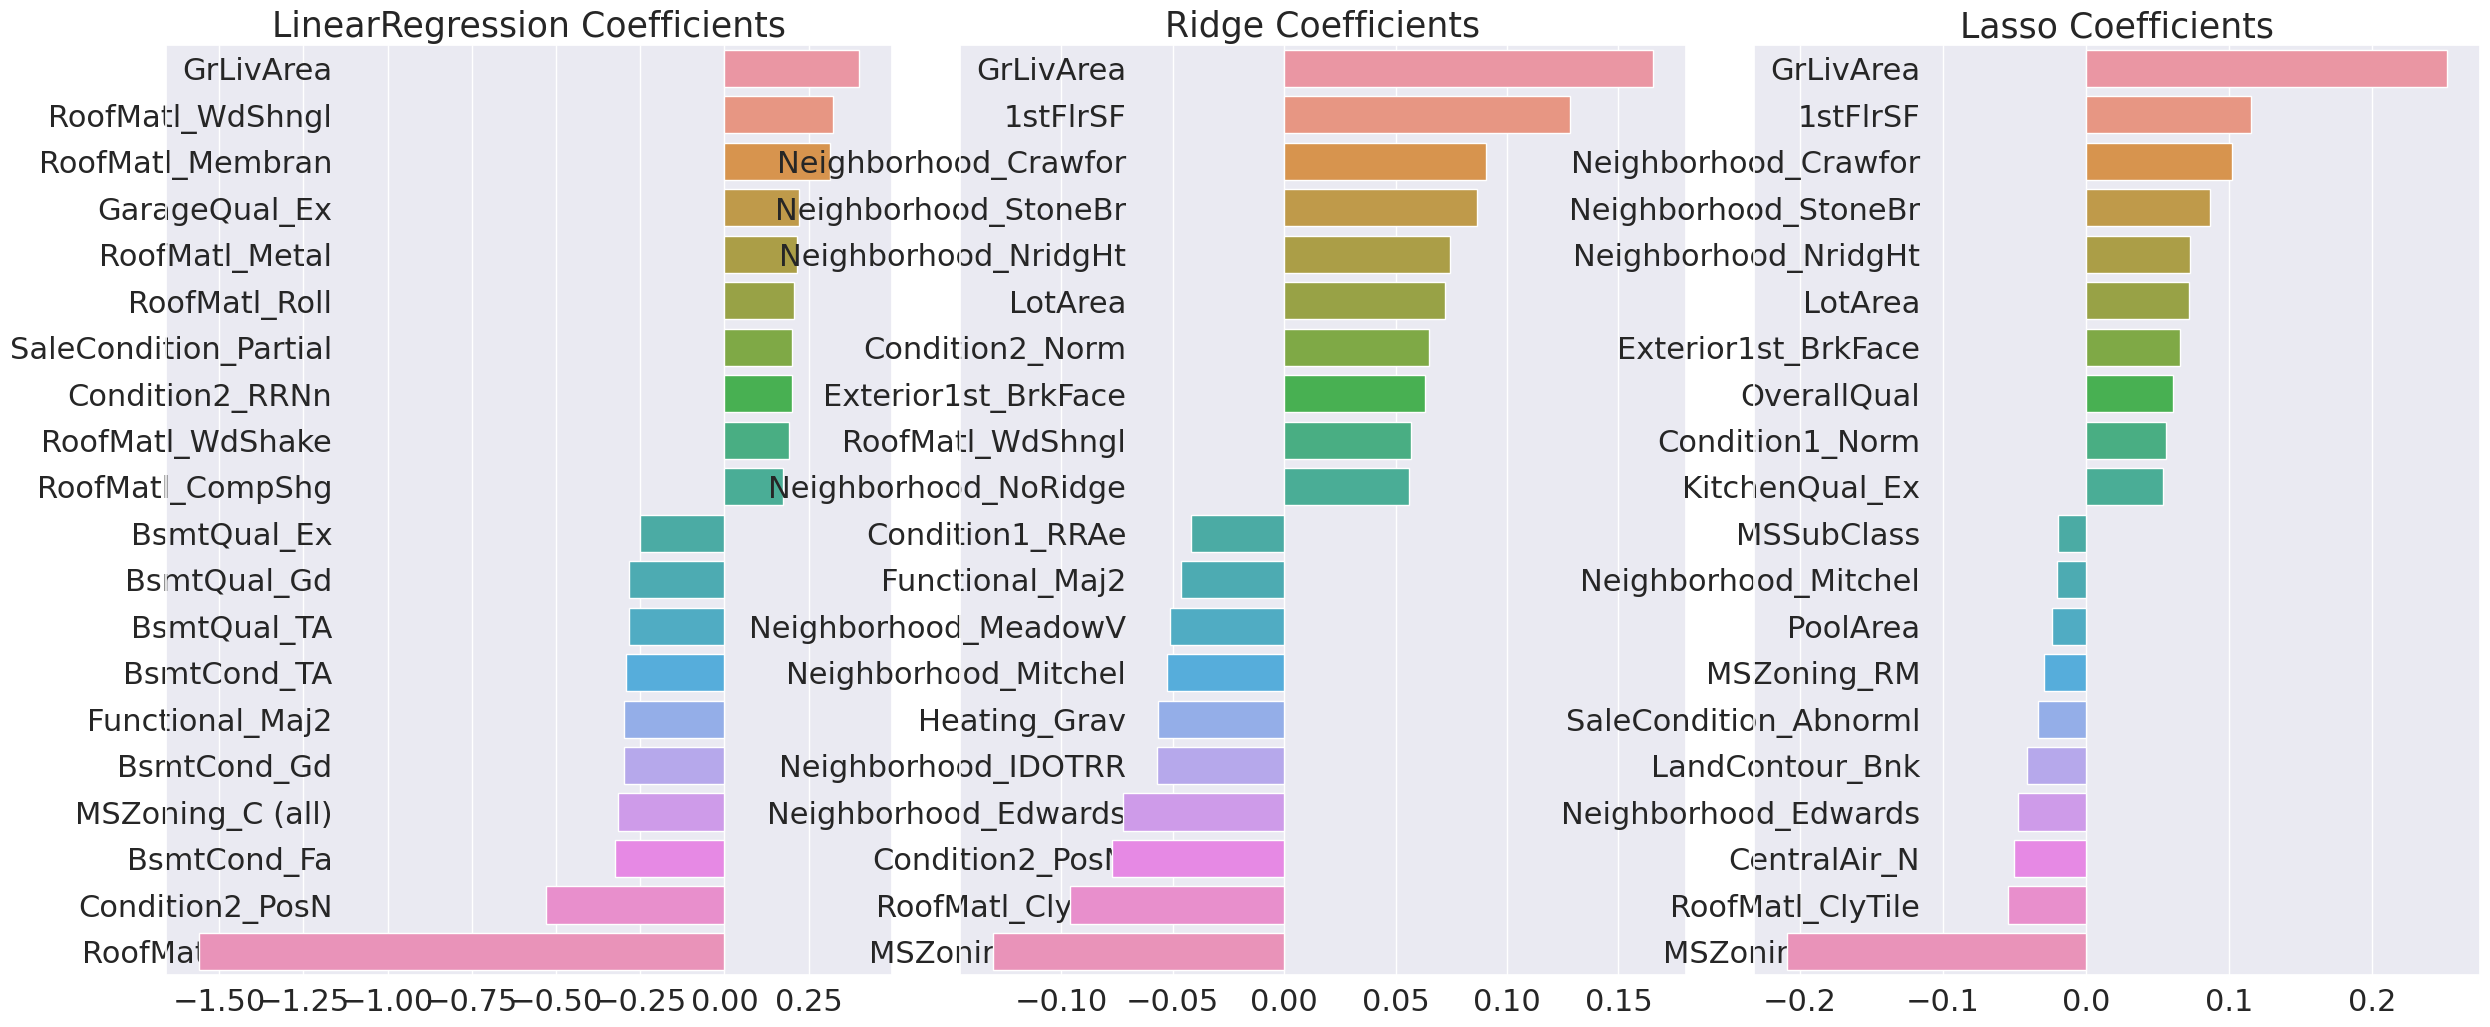

In [39]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
visualize_coefficient(models)

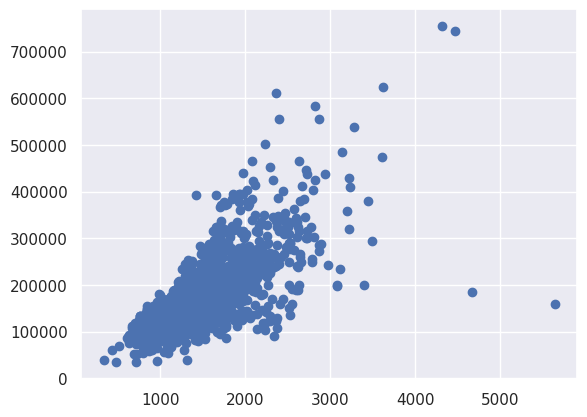

In [40]:
plt.scatter(x = df_origin['GrLivArea'], y=df_origin['SalePrice'])
plt.show()

In [41]:
cond1 = df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = df_ohe[cond1 & cond2].index

print(outlier_index.values)

df_ohe.drop(outlier_index, axis=0, inplace=True)

[ 523 1298]


In [42]:
y_target = df_ohe['SalePrice']
X_features = df_ohe.drop('SalePrice', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE : 0.1125, 최적 alpha : {'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE : 0.1122, 최적 alpha : {'alpha': 0.001}


LinearRegression RMSE: 0.129
Ridge RMSE: 0.103
Lasso RMSE: 0.1


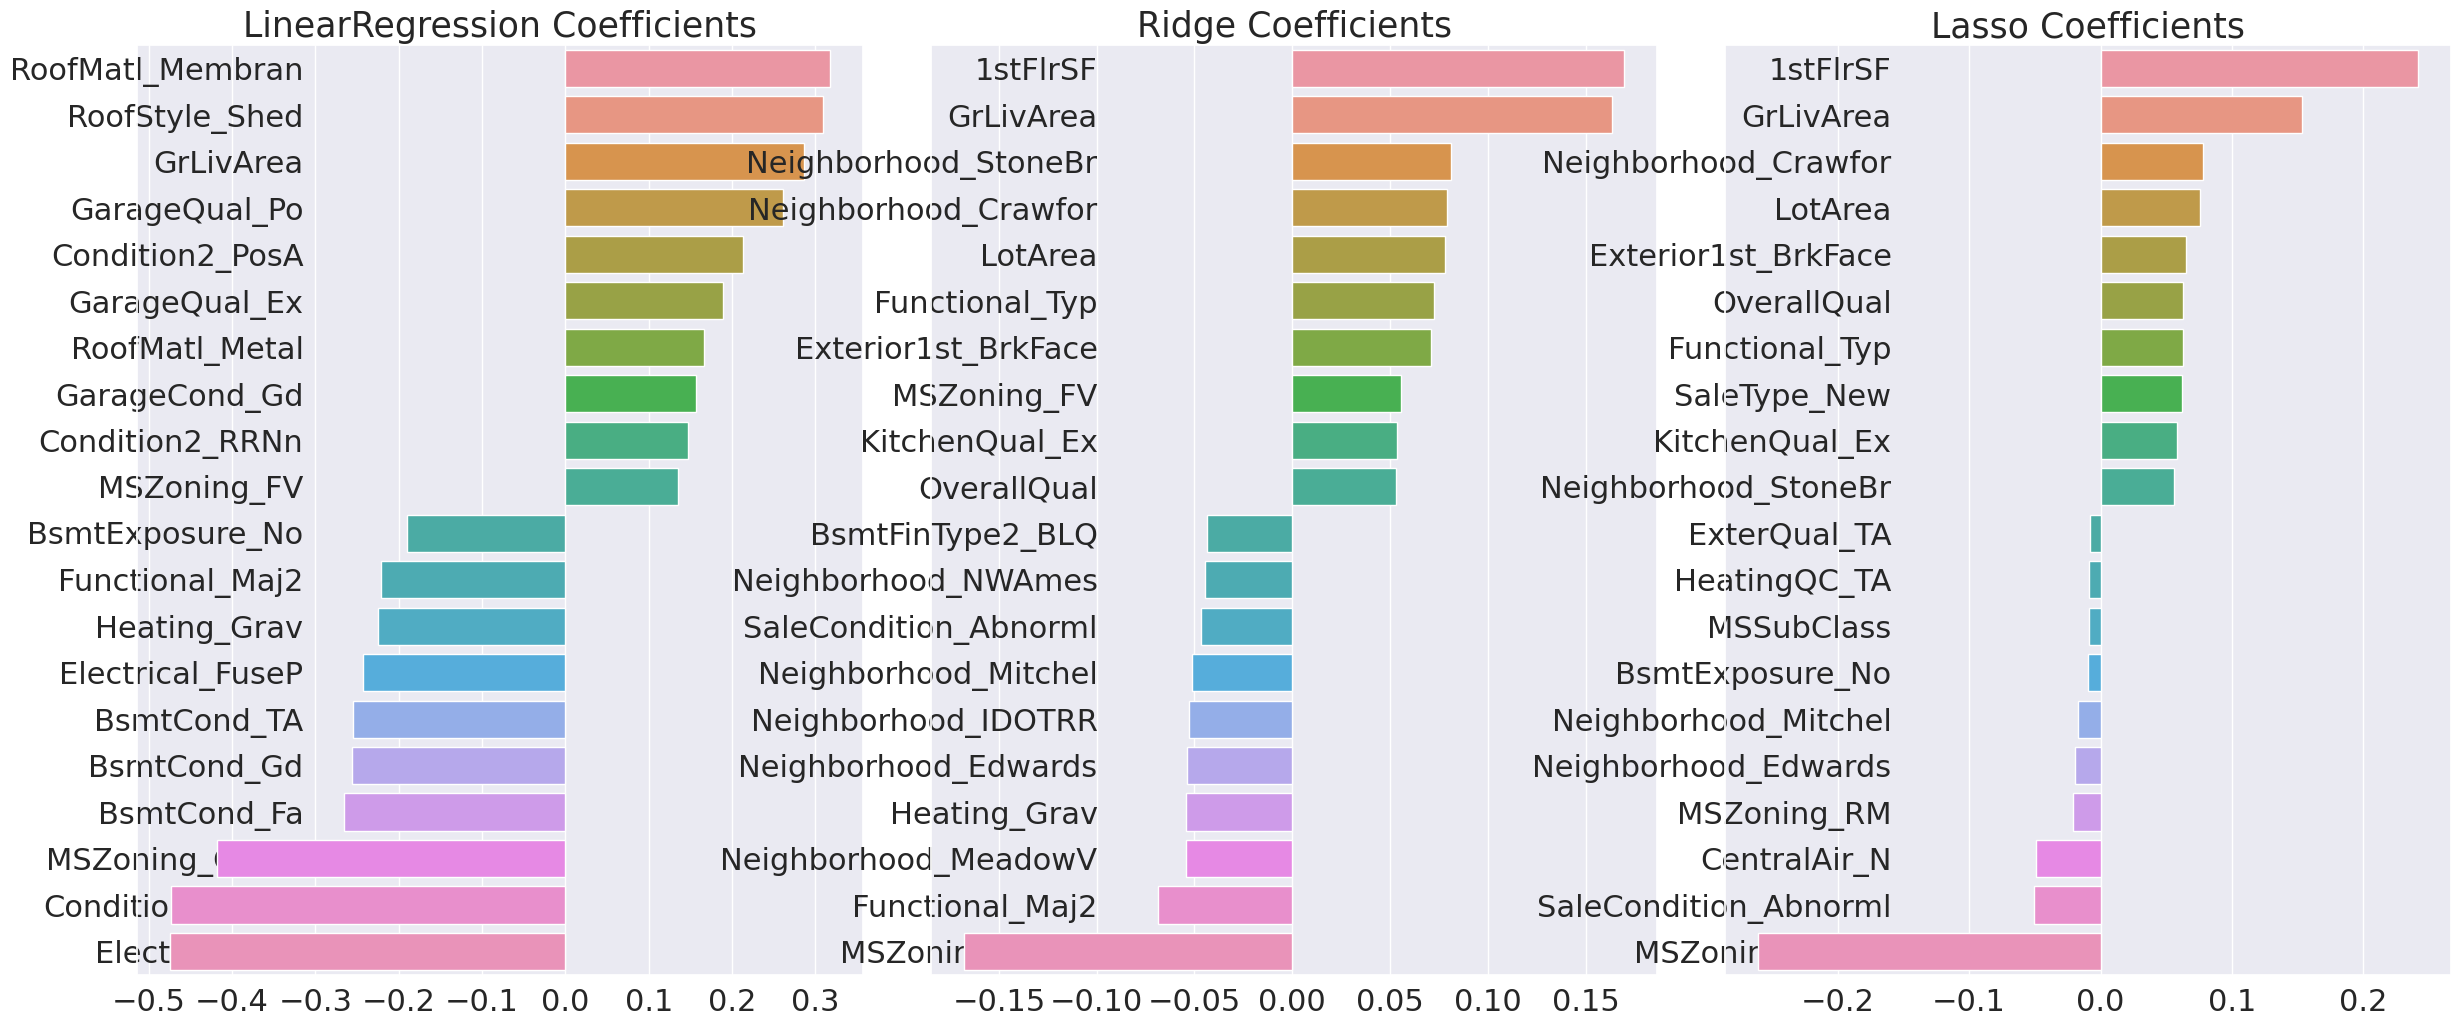

In [43]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
visualize_coefficient(models)

In [47]:
from xgboost import XGBRegressor

xgb_params={'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)

print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE : 0.1183, 최적 alpha : {'n_estimators': 1000}


In [48]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE : 0.1163, 최적 alpha : {'n_estimators': 1000}


In [55]:
from xgboost import plot_importance as xgb_imp
from lightgbm import plot_importance as lgbm_imp

xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)

models = [xgb_reg, lgbm_reg]
get_rmses(models)

XGBRegressor RMSE: 0.107
LGBMRegressor RMSE: 0.104


[0.1068349332939617, 0.10382510019327311]

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

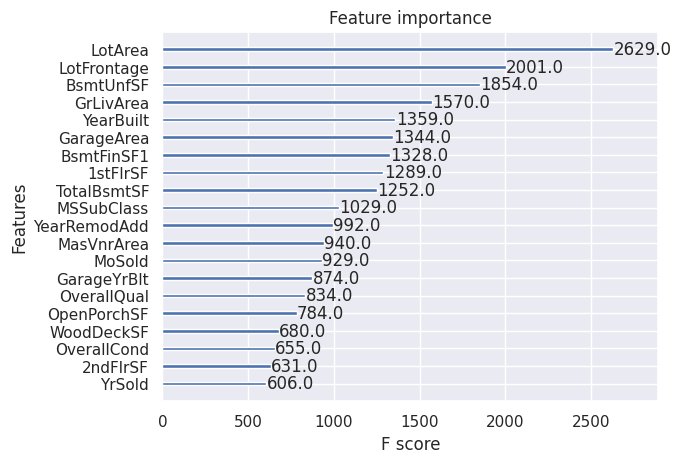

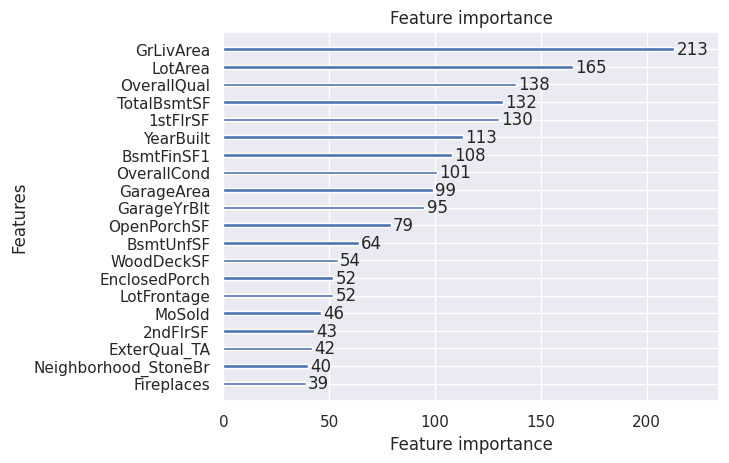

In [56]:
xgb_imp(xgb_reg, max_num_features=20)
lgbm_imp(lgbm_reg, max_num_features=20)

In [58]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print("{0} RMSE : {1}".format(key, rmse))


ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {
    '최종 혼합' : pred,
    'Ridge' : ridge_pred,
    'Lasso' : lasso_pred
}

get_rmse_pred(preds)


최종 혼합 RMSE : 0.10007930884470509
Ridge RMSE : 0.10345177546603267
Lasso RMSE : 0.10024170460890024


In [60]:
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5*xgb_pred + 0.5*lgbm_pred

preds = {
    '최종 혼합' : pred,
    'XGBM' : xgb_pred,
    'LGBM' : lgbm_pred
}

get_rmse_pred(preds)

최종 혼합 RMSE : 0.10145013149835881
XGBM RMSE : 0.1068349332939617
LGBM RMSE : 0.10382510019327311


In [63]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=False)
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, 'model start')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트 :', folder_counter, '시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        test_pred[:, folder_counter] = model.predict(X_test_n)

    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)

    return train_fold_pred, test_pred_mean

In [64]:
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge model start
	 폴드 세트 : 0 시작
	 폴드 세트 : 1 시작
	 폴드 세트 : 2 시작
	 폴드 세트 : 3 시작
	 폴드 세트 : 4 시작
Lasso model start
	 폴드 세트 : 0 시작
	 폴드 세트 : 1 시작
	 폴드 세트 : 2 시작
	 폴드 세트 : 3 시작
	 폴드 세트 : 4 시작
XGBRegressor model start
	 폴드 세트 : 0 시작
	 폴드 세트 : 1 시작
	 폴드 세트 : 2 시작
	 폴드 세트 : 3 시작
	 폴드 세트 : 4 시작
LGBMRegressor model start
	 폴드 세트 : 0 시작
	 폴드 세트 : 1 시작
	 폴드 세트 : 2 시작
	 폴드 세트 : 3 시작
	 폴드 세트 : 4 시작


In [66]:
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

meta_model_lasso = Lasso(alpha=0.0005)

meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print(rmse)

0.09732028871864243
